In [1]:
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import datetime
from statistics import mean,median,mode,stdev
import re
import seaborn as sns

C:\Users\Joshu\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Final Project (from AWS ML course)

## Predict whether a mammogram mass is benign or malignant

We'll be using the "mammographic masses" public dataset from the UCI repository (source: https://archive.ics.uci.edu/ml/datasets/Mammographic+Mass)

This data contains 961 instances of masses detected in mammograms, and contains the following attributes:


   1. BI-RADS assessment: 1 to 5 (ordinal)  
   2. Age: patient's age in years (integer)
   3. Shape: mass shape: round=1 oval=2 lobular=3 irregular=4 (nominal)
   4. Margin: mass margin: circumscribed=1 microlobulated=2 obscured=3 ill-defined=4 spiculated=5 (nominal)
   5. Density: mass density high=1 iso=2 low=3 fat-containing=4 (ordinal)
   6. Severity: benign=0 or malignant=1 (binominal)
   
BI-RADS is an assesment of how confident the severity classification is; it is not a "predictive" attribute and so we will discard it. The age, shape, margin, and density attributes are the features that we will build our model with, and "severity" is the classification we will attempt to predict based on those attributes.

Although "shape" and "margin" are nominal data types, which sklearn typically doesn't deal with well, they are close enough to ordinal that we shouldn't just discard them. The "shape" for example is ordered increasingly from round to irregular.


### Own attempt:

In [29]:
df = pd.read_csv('mammographic_masses.data.txt', na_values=['?'], names = ['BI-RADS', 'age', 'shape', 'margin', 'density', 'severity'])
df.head()

,BI-RADS,age,shape,margin,density,severity
0,5.0,67.0,3.0,5.0,3.0,1
1,4.0,43.0,1.0,1.0,NaN,1
2,5.0,58.0,4.0,5.0,3.0,1
3,4.0,28.0,1.0,1.0,3.0,0
4,5.0,74.0,1.0,5.0,NaN,1


In [30]:
df.describe()

,BI-RADS,age,shape,margin,density,severity
count,959.000000,956.000000,930.000000,913.000000,885.000000,961.000000
mean,4.348279,55.487448,2.721505,2.796276,2.910734,0.463059
std,1.783031,14.480131,1.242792,1.566546,0.380444,0.498893
min,0.000000,18.000000,1.000000,1.000000,1.000000,0.000000
25%,4.000000,45.000000,2.000000,1.000000,3.000000,0.000000
50%,4.000000,57.000000,3.000000,3.000000,3.000000,0.000000
75%,5.000000,66.000000,4.000000,4.000000,3.000000,1.000000
max,55.000000,96.000000,4.000000,5.000000,4.000000,1.000000


<AxesSubplot:>

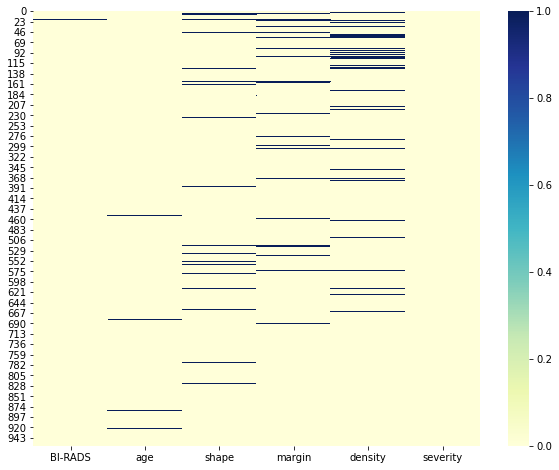

In [31]:
null_df = df.isnull()

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(null_df, cmap="YlGnBu")

In [39]:
# deal with null values - we can probably just drop them
df_dropped = df.dropna()

# or impute the mean of the column
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')  
imputer.fit(df)
df_imputed = imputer.transform(df)
df_imputed = pd.DataFrame(df_imputed, columns=df.columns)

# using KNN-imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputer.fit(df)
df_imputed_2 = imputer.transform(df)
df_imputed_2 = pd.DataFrame(df_imputed, columns=df.columns)

# using MICE - Multiple Iterations by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
mice_imputer = IterativeImputer()

# Fit and transform data
df_imputed_3 = mice_imputer.fit_transform(df)

# The result is a numpy array, convert it back to a DataFrame
df_imputed_3 = pd.DataFrame(df_imputed_3, columns=df.columns)

In [50]:
df_imputed_3[df.isnull().any(axis=1)] - df_imputed_2[df.isnull().any(axis=1)]

,BI-RADS,age,shape,margin,density,severity
1,0.0,0.000000,0.000000,0.000000,-0.027149,0.0
4,0.0,0.000000,0.000000,0.000000,0.026389,0.0
5,0.0,0.000000,0.000000,-1.478727,0.000000,0.0
6,0.0,0.000000,-0.334452,-0.371383,0.000000,0.0
7,0.0,0.000000,0.000000,-1.745908,0.000000,0.0
...,...,...,...,...,...,...
778,0.0,0.000000,0.431537,0.000000,0.000000,0.0
819,0.0,0.000000,0.000000,-0.526737,0.000000,0.0
824,0.0,0.000000,0.302692,0.000000,0.000000,0.0
884,0.0,7.388420,0.000000,0.000000,0.000000,0.0


In [51]:
# it's a categorical distribution - between zero and one, so let's try logistic regression
# and thereafter we can look at the coefficients for interpretability

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

logreg = LogisticRegression()
predictors = ['High', 'Low']
x = df_imputed.iloc[:,:-1]
y = df_imputed['severity']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

logreg.fit(x_train, y_train)
Y1 = logreg.predict(x)
print(f"Scores - Train: {logreg.score(x_train,y_train)}, Test: {logreg.score(x_test, y_test)}, Overall: {logreg.score(x, y)}")

Scores - Train: 0.8214285714285714, Test: 0.8512110726643599, Overall: 0.8303850156087409


In [52]:
# apply k-fold cross-validation

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Define the number of folds for cross-validation
k = 5

# Create a KFold object
kfold = KFold(n_splits=k, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(logreg, x, y, cv=kfold, scoring='accuracy')
print(f"Average Accuracy: {scores.mean()}")

Average Accuracy: 0.8282815198618307


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np


# define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": svm.SVC(probability=True),  # ensure probability=True to use predict_proba for AUC-ROC
    "Multi-layer Perceptron": MLPClassifier(random_state=42, max_iter=300),
    "XGB": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

# function to train and evaluate model
def train_and_evaluate_model(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)  # to handle divide by zero
    precision = report["weighted avg"]["precision"]
    recall = report["weighted avg"]["recall"]
    f1_score = report["weighted avg"]["f1-score"]
    y_prob = model.predict(x_test)
    roc_auc = roc_auc_score(y_test, y_prob, multi_class="ovr")  # "ovr" for multiclass
    return accuracy, precision, recall, f1_score, roc_auc

# evaluate each model
results = {}
for name, model in models.items():
    results[name] = train_and_evaluate_model(model)

# tabulate results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'])
results_df


C:\Users\Joshu\anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\Joshu\anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


,Accuracy,Precision,Recall,F1-score,AUC-ROC
Logistic Regression,0.851211,0.852226,0.851211,0.851463,0.851247
Random Forest,0.799308,0.800178,0.799308,0.799590,0.798258
SVM,0.757785,0.766557,0.757785,0.758541,0.762592
Multi-layer Perceptron,0.823529,0.831775,0.823529,0.824093,0.828804
XGB,0.816609,0.816256,0.816609,0.816184,0.812185


In [58]:
# using MICE imputated values instead
x = df_imputed_3.iloc[:,:-1]
y = df_imputed_3['severity']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

# evaluate each model
results = {}
for name, model in models.items():
    results[name] = train_and_evaluate_model(model)

# tabulate results
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC'])
results_df

C:\Users\Joshu\anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\Joshu\anaconda3\lib\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


,Accuracy,Precision,Recall,F1-score,AUC-ROC
Logistic Regression,0.840830,0.841290,0.840830,0.840899,0.841132
Random Forest,0.788927,0.789147,0.788927,0.788572,0.787408
SVM,0.778547,0.778547,0.778547,0.778547,0.778098
Multi-layer Perceptron,0.840830,0.840830,0.840830,0.840830,0.840508
XGB,0.799308,0.803948,0.799308,0.797701,0.795782


In [56]:
# interpretability of results - using logreg as it is the best performing! 
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

# Standardize data
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

logreg.fit(x_train,y_train)
weights = pd.DataFrame(abs(logreg.coef_), columns = x.columns)

weights

,BI-RADS,age,shape,margin,density
0,1.967356,0.779223,0.638289,0.535329,0.00884


### Using Tensorflow instead (allows for more hyperparameter tuning than scikit-learn)

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    #4 feature inputs going into an 6-unit layer (more does not seem to help - in fact you can go down to 4)
    model.add(Dense(6, input_dim=4, kernel_initializer='normal', activation='relu'))
    # "Deep learning" turns out to be unnecessary - this additional hidden layer doesn't help either.
    #model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    # Output layer with a binary classification (benign or malignant)
    model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
    # Compile model; rmsprop seemed to work best
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [ ]:
import tensorflow as tf
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load data
data = load_iris()
X = data.data
y = data.target.reshape(-1, 1)

# One-hot encode targets for softmax
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(10, activation='relu'),
  tf.keras.layers.Dense(3, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=100)

# Test the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test accuracy: ", accuracy)
